# A Story Using Data

This time we decided to open a small robot-run cafe in Los Angeles. The project is promising but expensive, so together with our partners we decided to try to attract investors. They are interested in the current market conditions. So we need to find out what is going on with restaurants in LA.

## Purpose of the analysis

To prepare market research using open-source data on restaurants in LA.

## Initialization

In [52]:
# Loading all the libraries
!pip install sidetable -qq
import sidetable
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from scipy import stats as st
from functools import reduce
from dateutil.relativedelta import relativedelta
import datetime
from datetime import timedelta
!pip install usaddress -qq
import usaddress as usad

### Explore initial Data

We have one table where is information about places in LA The columns are:

* `id` - Place ID
* `object_name` - Name of the place
* `address` - Address of the place
* `chain` - Info whether the place is a chain of places or not.
* `object_type` - Type of the place (restaurant, Cafe, Pizza etc.)
* `number` - number of seats the place has.

In [54]:
# Load the data file
path = '9prj//'

try:
    df = pd.read_csv('/datasets/rest_data_us.csv')
except FileNotFoundError:
    df = pd.read_csv(path+'rest_data_us.csv')

In [55]:
# printing the general/summary information about df
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9651 entries, 0 to 9650
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           9651 non-null   int64 
 1   object_name  9651 non-null   object
 2   address      9651 non-null   object
 3   chain        9648 non-null   object
 4   object_type  9651 non-null   object
 5   number       9651 non-null   int64 
dtypes: int64(2), object(4)
memory usage: 452.5+ KB


In [56]:
# print a sample of data from df
df.head()

,id,object_name,address,chain,object_type,number
0,11786,HABITAT COFFEE SHOP,3708 N EAGLE ROCK BLVD,False,Cafe,26
1,11787,REILLY'S,100 WORLD WAY # 120,False,Restaurant,9
2,11788,STREET CHURROS,6801 HOLLYWOOD BLVD # 253,False,Fast Food,20
3,11789,TRINITI ECHO PARK,1814 W SUNSET BLVD,False,Restaurant,22
4,11790,POLLEN,2100 ECHO PARK AVE,False,Restaurant,20


In [57]:
# print a sample of data from df
df.tail(5)

,id,object_name,address,chain,object_type,number
9646,21432,HALL OF JUSTICE,217 W TEMPLE AVE,False,Restaurant,122
9647,21433,FIN-MELROSE,5750 MELROSE AVE,False,Restaurant,93
9648,21434,JUICY WINGZ,6741 HOLLYWOOD BLVD,True,Fast Food,15
9649,21435,MEDIDATE COFFEE,548 S SPRING ST STE 100,False,Cafe,6
9650,21436,CAFE SPROUTS,1300 S SAN PEDRO ST STE 111,True,Restaurant,19


In [58]:
# print a sample of data from df
df.sample(5)

,id,object_name,address,chain,object_type,number
2857,14643,EL BUEN GUSTO,3140 N GLENDALE BLVD,True,Restaurant,43
8623,20409,TROPICALIA,1964 HILLHURST AVE,False,Restaurant,40
314,12100,PRONTO CAFFE & TEA,3530 WILSHIRE BLVD STE 102,False,Restaurant,41
3942,15728,STARBUCKS COFFEE #13222,800 W OLYMPIC BLVD STE 102,True,Cafe,7
4652,16438,PASTELERIA Y PANADERIA EL PANON BAKERY,2109 S SAN PEDRO ST,True,Bakery,24


## Data preprocessing

We have a few problems with the chain column. There are some missing values and we need to change the type of the column to boolean because there is True or False value that gives us info about the type of the place, whether it is chain or not. We will also change the name of `number` column to `seats_n` in order to understand more clearly what we see in that column.

In [62]:
#Changing the type of `number` column
df=df.rename(columns={'number':'seats_n'})

#examining info but missing values
df.stb.missing(style=True)

,missing,total,percent
chain,3,"9,651",0.03%
id,0,"9,651",0.00%
object_name,0,"9,651",0.00%
address,0,"9,651",0.00%
object_type,0,"9,651",0.00%
seats_n,0,"9,651",0.00%


We have 0.03% of missing values in `chain` column. We can simply remove them from our analysis.

In [64]:
#Removing missing rows
df = df.dropna().reset_index()

#Checking that we have successfully removed missing rows
df.stb.missing(style=True)

,missing,total,percent
index,0,"9,648",0.00%
id,0,"9,648",0.00%
object_name,0,"9,648",0.00%
address,0,"9,648",0.00%
chain,0,"9,648",0.00%
object_type,0,"9,648",0.00%
seats_n,0,"9,648",0.00%


We've successfully removed missing values rows. Now we can change the type of `chain` column to boolean.

In [66]:
#Changing the type of the `chain` column
df['chain']=df['chain'].astype('bool')

#Checking the updated general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9648 entries, 0 to 9647
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   index        9648 non-null   int64 
 1   id           9648 non-null   int64 
 2   object_name  9648 non-null   object
 3   address      9648 non-null   object
 4   chain        9648 non-null   bool  
 5   object_type  9648 non-null   object
 6   seats_n      9648 non-null   int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 461.8+ KB


In [67]:
# print a sample of data from df
df.sample(5)

,index,id,object_name,address,chain,object_type,seats_n
6640,6640,18426,PHO PASTEUR EXPRESS RESTAURANT,1025 N STATE ST,True,Fast Food,42
4656,4656,16442,MCDONALD'S #5674,1007 N WESTERN AVE,True,Fast Food,177
5694,5694,17480,CANELE,3219 GLENDALE BLVD,False,Restaurant,144
1441,1441,13227,AWOOLIM,928 S WESTERN AVE STE 125,False,Restaurant,25
5985,5985,17771,BURGER KING #2547,1011 N WESTERN AVE,True,Fast Food,87


We've changed the name of the column where we have the number of seats for each place, deleted just 3 rows with missing values in chain column and changed that column to boolean. Let's check data for duplicates and for values we have in `object_type` column.

In [69]:
df.duplicated().sum()

0

In [70]:
#Checking object_type column
df.object_type.unique()

array(['Cafe', 'Restaurant', 'Fast Food', 'Bakery', 'Bar', 'Pizza'],
      dtype=object)

No duplicates, just 6 categories without repetition. Now we can start our analysis.

## Analyzing place types, chain factor and number of seats

In order to find out the characteristics we will investigate the proportions of the various types of establishments, find out the proportions of chain and nonchain establishments and determine which type of establishment is typically a chain.

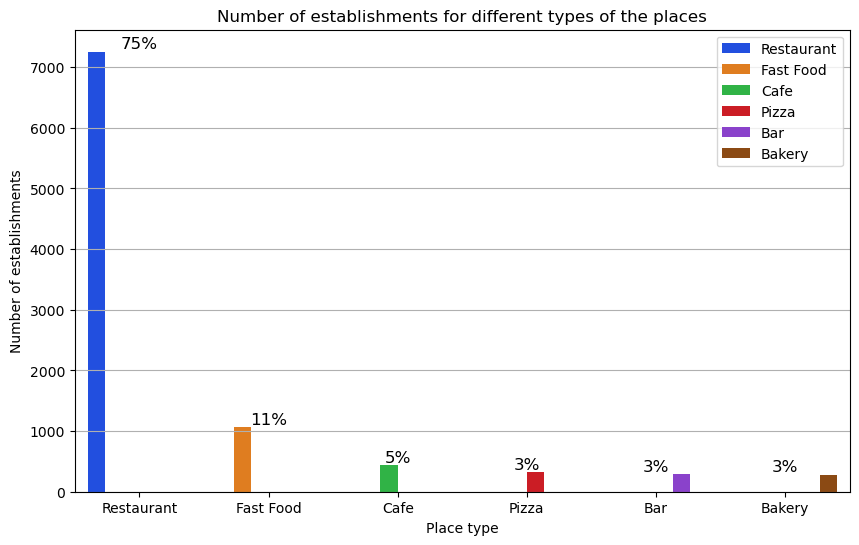

In [75]:
#Plotting a bar graph to calculate the proportion of different trpes of the places
#Preparing the table
types = df.groupby('object_type')['id'].count().sort_values(ascending=False).reset_index()
#Plotting a graph
fig, ax = plt.subplots(figsize=(10,6))
palette = sns.color_palette('bright', n_colors=len(types.object_type))
ax=sns.barplot(data=types, x='object_type', y='id', hue='object_type', palette=palette)
ax.grid(axis='y')



#Adding percent ratio to the graph
total_count=types['id'].sum()
for i, row in types.iterrows():
    count = row['id']
    share = round(count/total_count, 2)
    ax.annotate(f'{share:.0%}', xy=(i, count), ha='center', va='bottom', fontsize=12)

#Adding additional info to the graph
ax.set_title('Number of establishments for different types of the places')
ax.set_xlabel('Place type')
ax.set_ylabel('Number of establishments')
plt.legend()
plt.show()

The most of the food places in LA are restaurants. Their share is 75%. The share of Fast food is 11% and each other place has its share not bigger than 5% of the total number of places.
Let's add info about chain and not chain places to our graph. Then we will plot a chart with overall proportion of chain and non-chain establishments.

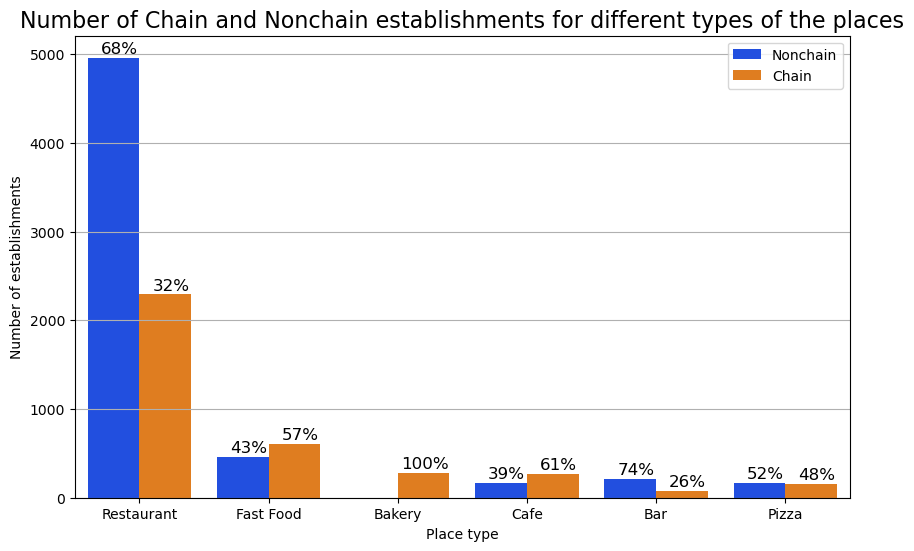

In [78]:
#Preparing the table with chain column for each object type
types1 = df.groupby(['object_type', 'chain'])['id'].count().sort_values(ascending=False).reset_index()

#Plotting bar graph
fig, ax = plt.subplots(figsize=(10,6))
palette = sns.color_palette('bright', n_colors=len(types1.chain.unique()))
ax = sns.barplot(data=types1, x='object_type', y='id', hue='chain', palette=palette)

#Adjusting legend
new_labels = {'False': 'Nonchain', 'True': 'Chain'}
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, [new_labels[label] for label in labels])
ax.grid(axis='y')

# Adding annotations
for type_idx, object_type in enumerate(types1['object_type'].unique()):
    chain_counts = types1.loc[(types1['object_type'] == object_type) & (types1['chain'] == True), 'id'].values
    non_chain_counts = types1.loc[(types1['object_type'] == object_type) & (types1['chain'] == False), 'id'].values
    
    if chain_counts.any() and non_chain_counts.any():
        # Add annotation for chain objects
        ax.annotate(f"{(chain_counts[0] / (chain_counts[0] + non_chain_counts[0])):.0%}", 
                    xy=(type_idx+0.1, chain_counts[0] + 50), fontsize=12, color='black')
        
        # Add annotation for non-chain objects
        ax.annotate(f"{(non_chain_counts[0] / (chain_counts[0] + non_chain_counts[0])):.0%}", 
                    xy=(type_idx-0.3, non_chain_counts[0] + 50), fontsize=12, color='black')
    elif chain_counts.any():
        # Add annotation for chain objects
        ax.annotate(f"{1:.0%}", xy=(type_idx+0.03, chain_counts[0] + 50), fontsize=12, color='black')
    elif non_chain_counts.any():
        # Add annotation for non-chain objects
        ax.annotate(f"{1:.0%}", xy=(type_idx-0.3, non_chain_counts[0] + 50), fontsize=12, color='black')

#Adding additional info to the graph
ax.set_title('Number of Chain and Nonchain establishments for different types of the places', fontsize=16)
ax.set_xlabel('Place type')
ax.set_ylabel('Number of establishments')
        
plt.show()

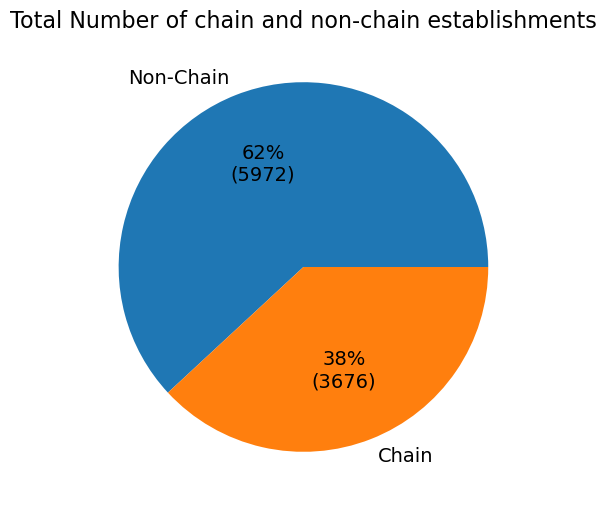

In [79]:
# Summing up and calculating number of chain and non chain establishments
df_cf = df.groupby('chain', as_index=True)['id'].count().reset_index()

# Creating variables for characteristics and chain / non-chain parameter
chain = ['Non-Chain', 'Chain']

# Plotting a pie chart with annotation
fig, ax = plt.subplots(figsize=(10,6))
autopct_str = lambda x: f"{x:.0f}%\n({x/100*df_cf['id'].sum():.0f})"
ax.pie(df_cf['id'], labels=chain, autopct=autopct_str, textprops={'fontsize': 14})
ax.set_title('Total Number of chain and non-chain establishments', fontsize=16)
plt.show()

Now we see that all bakeries are chain and most of cafes and fast-food places are chain (61% of cafes and 57% of fast-food). Bars and Restaurants are mostly non-chain (75% of Bars and 68% of restaurants). The majority of objects are restaurants, so the will affect to the total result an we see that most objects are non-chain, although it depends on type of the object. For Pizzas we have a draw (52% is non-chain and 48% are chain).

Let's analyze characteristics of chain places and find out how many seats and establishments they have. We will filter chain establishments from our data and for each venue we will find number of establishments and mean number of seats. Then we will plot pairplot chart.

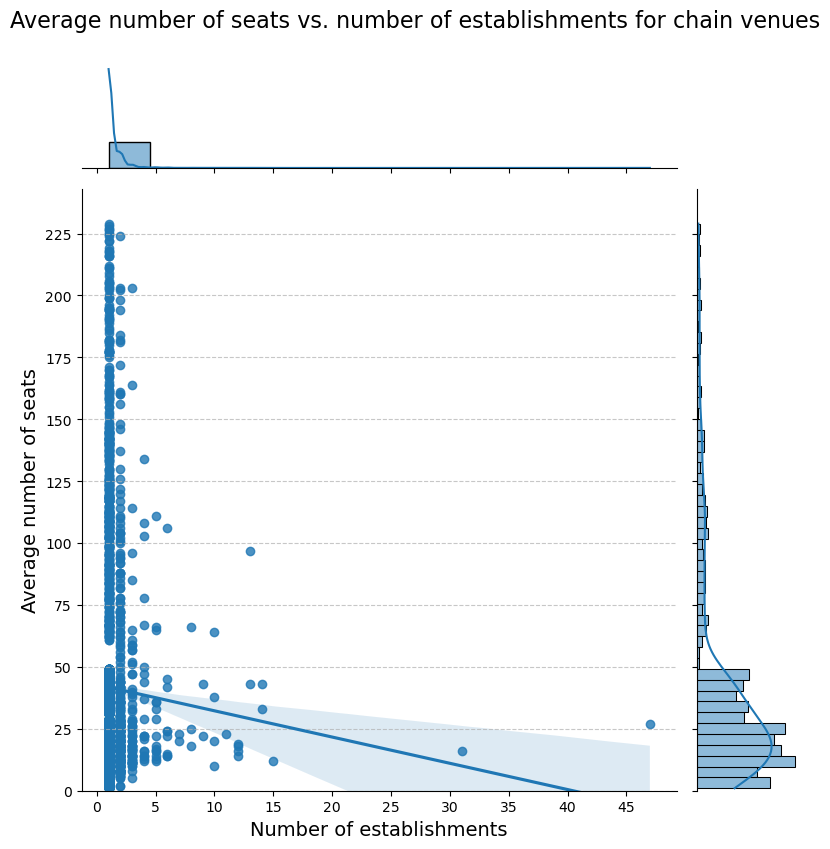

80% of chain venues have 1 establishment,
80% of chain venues have 49 seats per establishment in average.


In [82]:
# Filtering chain data
df_chain = df.query('chain')

# Grouping data by name of the venue and calculating number of establishments and average number of seats
df_chain_gr = df_chain.groupby('object_name').agg({'id': 'count', 'seats_n': 'sum'}).reset_index()
# Renaming column id
df_chain_gr = df_chain_gr.rename(columns={'id': 'object_count'})

# Calculating average number of seats for each venue
df_chain_gr['seats_avg'] = (round(df_chain_gr.seats_n / df_chain_gr.object_count, 0)).astype('int')

# Plotting joint plot chart
g = sns.jointplot(data=df_chain_gr, x='object_count', y='seats_avg', kind='reg', height=8, ratio=5)

g.fig.suptitle('Average number of seats vs. number of establishments for chain venues', fontsize=16, y=1.05)
g.ax_joint.set_xlabel('Number of establishments', fontsize=14)
g.ax_joint.set_ylabel('Average number of seats', fontsize=14)
g.ax_joint.set_yticks(range(0, 250, 25))
g.ax_joint.set_xticks(range(0, 50, 5))
g.ax_joint.set_ylim(0, None)
g.ax_joint.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

print(f'''80% of chain venues have {np.percentile(df_chain_gr.object_count, 80):.0f} establishment,
80% of chain venues have {np.percentile(df_chain_gr.seats_avg, 80):.0f} seats per establishment in average.''')

We see that most of the chain venues have just 1 establishment in LA and half of chain venues have about 25 seats per establishment in average. We see also some kind of regression. So, the more establishments a venue has the less number of seats there are in its establishments. 80% of all chain venues have not more than 49 seats in its establishments. Generally speaking we can say that typical chain venue has just one establishment and number of seats about 25-30.

Let's look at the average number of seats disregarding the chain factor.

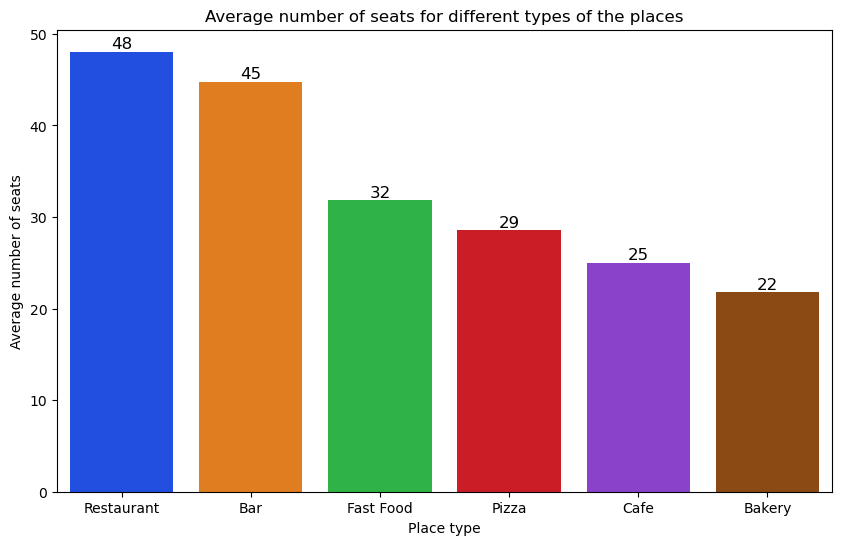

In [85]:
#Plotting a bar graph to calculate the proportion of different number of seats in different types of the places
#Preparing the table
seats = df.groupby('object_type')['seats_n'].mean().sort_values(ascending=False).reset_index()
#Plotting a graph
fig, ax = plt.subplots(figsize=(10,6))
palette = sns.color_palette('bright', n_colors=len(seats.object_type))
ax=sns.barplot(data=seats, x='object_type', y='seats_n', palette=palette, label=seats['object_type'])

#Adding numeric info
total_count=seats['seats_n'].sum()
for i, row in seats.iterrows():
    count = row['seats_n']
    ax.annotate(f'{count:.0f}', xy=(i, count), ha='center', va='bottom', fontsize=12)

#Adding additional info to the graph
ax.set_title('Average number of seats for different types of the places')
ax.set_xlabel('Place type')
ax.set_ylabel('Average number of seats')
plt.show()

Restaurants and bars have the biggest average number of seats (45-48) where bakeries and cafes have the smallest number of seats (22-25). Fast food and pizzas have 28-32 seats in average.

## Analyzing address information of different places

In order to analyze what is geographical distribution of the places we need to extract street info from the `address` column let's create new column with the name of the street. We need to install us address library for that. Let's install it and look how it works with our address column.

In [90]:
#Testing an example
street_ex = df.loc[17, 'address']
usad.parse(street_ex)

[('244', 'AddressNumber'),
 ('S', 'StreetNamePreDirectional'),
 ('OXFORD', 'StreetName'),
 ('AVE', 'StreetNamePostType'),
 ('#', 'OccupancyIdentifier'),
 ('5', 'OccupancyIdentifier')]

Now we have a list where all parts of the address are divided by parameters. We can make dictionary from that list, but we need to change the order first, so keys will become names of the sections. Then we can extract all values regarding the street name. Let's try to do it with this example.

In [92]:
#creating variable with raw address and an empty dictionary
raw_add = usad.parse(street_ex)
address_dict={}

#Creating a dictonary with adress
for i in raw_add:
    address_dict.update({i[1]:i[0]})
address_dict

#Extracting street from the dictionary
street = address_dict['StreetNamePreDirectional']+' '+address_dict['StreetName']+' '+address_dict['StreetNamePostType']
print('For address:', street_ex, 'we have street name:', street)

For address: 244 S OXFORD AVE # 5 we have street name: S OXFORD AVE


It works well. Let's write a function which will extract street from the address. Not all parameters can be in `address` column, so we will make conditions to fix it.

In [94]:
#Defining a function to extract street from the address
def street_ext(row):
    raw_add = usad.parse(row)
    address_dict = {}
    for i in raw_add:
#Updating the dictionary        
        address_dict.update({i[1]:i[0]})
#Checking if there are needed values in dictionary n        
        if ('StreetNamePreDirectional' in address_dict.keys() and 'StreetName' in address_dict.keys() 
            and 'StreetNamePostType' in address_dict.keys()):
            street = (address_dict['StreetNamePreDirectional']+' '+address_dict['StreetName']+' '
                      +address_dict['StreetNamePostType'])
        elif 'StreetNamePreDirectional' in address_dict.keys() and 'StreetName' in address_dict.keys():
            street = address_dict['StreetNamePreDirectional']+' '+address_dict['StreetName']
        elif 'StreetName' in address_dict.keys() and 'StreetNamePostType' in address_dict.keys():
            street = address_dict['StreetName'] + address_dict['StreetNamePostType']
        elif 'StreetName' in address_dict.keys():
            street = address_dict['StreetName']
        else:
            street='No street'
    return street

#Creating column `street` in df
df['street'] = df.address.apply(street_ext)

#Checking result
df.sample(5)

,index,id,object_name,address,chain,object_type,seats_n,street
5622,5622,17408,33 TAPS,6263 HOLLYWOOD BLVD,False,Restaurant,153,HOLLYWOODBLVD
7380,7380,19166,PLAYAS EL SALVADOR REST,333 N BEAUDRY AVE,False,Restaurant,18,N BEAUDRY AVE
9050,9053,20839,THE SIPP,1855 MANCHESTER AVE # 112,False,Restaurant,9,MANCHESTERAVE
5891,5891,17677,TOUS LES JOURS,2736 W OLYMPIC BLVD,True,Restaurant,9,W OLYMPIC BLVD
8919,8922,20708,PIPS ON LA BREA,1356 S LA BREA AVE,False,Restaurant,122,S BREA AVE


Let's look whether we have 'No street' values in our street column and fix it if needed.

In [96]:
#Filtering street to check for mistakes
df.query('street=="No street"')

,index,id,object_name,address,chain,object_type,seats_n,street
1888,1888,13674,MAGDALENO DEBBIE,OLVERA ST E17,False,Restaurant,15,No street
3719,3719,15505,LAS ANITAS,OLVERA ST 26,False,Restaurant,38,No street
7003,7003,18789,D.K. DONUTS,1033 1/2 LOS ANGELES ST,False,Fast Food,8,No street
7281,7281,19067,CIELITO LINDO,OLVERA ST 23,False,Restaurant,2,No street
7319,7319,19105,JUANITA'S CAFE,OLVERA ST 20,False,Restaurant,12,No street
7321,7321,19107,KITTY'S SNOW CONES,OLVERA ST 2,False,Restaurant,11,No street
7437,7438,19224,LA GOLONDRINA,OLVERA ST W17,False,Restaurant,204,No street
7739,7741,19527,RODOLFO'S RESTAURANT,OLVERA ST 5,True,Restaurant,4,No street


We have only two streets Olivera and Los Angeles with missing info. Let's look at values in dictionary that we have for those streets.

In [98]:
#Getting info about Olivera street
street_ex = df.loc[1888, 'address']
usad.parse(street_ex)

[('OLVERA', 'PlaceName'), ('ST', 'StateName'), ('E17', 'ZipCode')]

Here we have PlaceName instead of StreetName. And all values start with OLIVERA. So we can simply fix it adding the condition for that case. And we have just one more value about Los Angeles. Let's add 2 conditions and update our function.

In [100]:
#Defining an updated function to extract street from the address taking into account Olivera and Los Angeles
def street_ext(row):
    raw_add = usad.parse(row)
    address_dict = {}
    for i in raw_add:
#Updating the dictionary        
        address_dict.update({i[1]:i[0]})
#Checking Los Angeles
        if row== '1033 1/2 LOS ANGELES ST':
            street='LOS ANGELES ST'
#Checking Olivera
        elif row.startswith('OLVERA'):
            street='OLVERA ST'
#Checking if there are other needed values in dictionary n        
        elif ('StreetNamePreDirectional' in address_dict.keys() and 'StreetName' in address_dict.keys() 
            and 'StreetNamePostType' in address_dict.keys()):
            street = (address_dict['StreetNamePreDirectional']+' '+address_dict['StreetName']+' '
                      +address_dict['StreetNamePostType'])
        elif 'StreetNamePreDirectional' in address_dict.keys() and 'StreetName' in address_dict.keys():
            street = address_dict['StreetNamePreDirectional']+' '+address_dict['StreetName']
        elif 'StreetName' in address_dict.keys() and 'StreetNamePostType' in address_dict.keys():
            street = address_dict['StreetName'] + address_dict['StreetNamePostType']
        elif 'StreetName' in address_dict.keys():
            street = address_dict['StreetName']
        else:
            street='No street'
    return street

#Creating column `street` in df
df['street'] = df.address.apply(street_ext)

#Checking result
df.sample(5)

,index,id,object_name,address,chain,object_type,seats_n,street
8890,8893,20679,EGGSLUTS,8500 BEVERLY BLVD # 101,True,Restaurant,23,BEVERLYBLVD
7624,7626,19412,SURF CITY SQUEEZE,3650 W MLK BLVD,True,Restaurant,24,W MLK BLVD
2010,2010,13796,BULACAN BAKERY AND CATERING,2256 COLORADO BLVD # 110,True,Bakery,3,COLORADOBLVD
7161,7161,18947,ISLAND FRESH,5101 W PICO BLVD,False,Restaurant,11,W PICO BLVD
8146,8148,19934,ANTOJITOS LISETH,3324 W 6TH ST STE E1,False,Restaurant,11,W 6TH ST


In [102]:
#Checking if we some 'No street' values left
df[df['street']=='No street']

,index,id,object_name,address,chain,object_type,seats_n,street


We have successfully created `street` column. No we can analyze geographic parameters of our places. Let's find TOP 10 streets by number of restaurants. We can group df by `street` column, then we sort values and choose TOP 10 rows. We will plot a bar graph to visualize it.

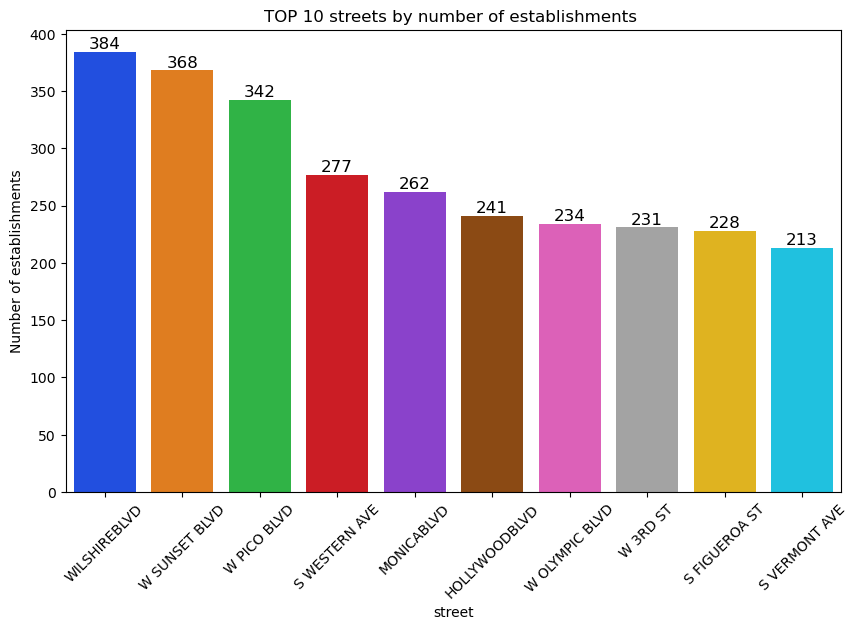

In [104]:
#Choosing TOP 10 streets with groupby and sort_values
street_top = df.groupby('street')['id'].count().sort_values(ascending=False).reset_index().head(10)
#Changing column name
street_top=street_top.rename(columns={'id':'Number of establishments'})

#Plotting bar graph
fig, ax = plt.subplots(figsize=(10,6))
palette = sns.color_palette('bright', n_colors=len(street_top.street))
ax=sns.barplot(data=street_top, x='street', y='Number of establishments', palette=palette, label=street_top['street'])

#Adding numeric info
total_count=street_top['Number of establishments'].sum()
for i, row in street_top.iterrows():
    count = row['Number of establishments']
    ax.annotate(f'{count:.0f}', xy=(i, count), ha='center', va='bottom', fontsize=12)

#Adding additional info to the graph
ax.set_title('TOP 10 streets by number of establishments ')
ax.set_xticklabels(street_top['street'], rotation=45)
plt.show()

All top 10 streets have more than 200 establishments on each, and our TOP 3 are: Wilshire blvd, W Sunset blvd, and W Pico blvd, where there are more than 300 places on each street. Lets look at outsiders. We will find out how many streets have just one establishment.

In [107]:
#Finding number of streets with only one establishment.
street_1 = df.groupby('street')['id'].count().reset_index().query('id==1')['id'].sum()
print('There are', street_1, 'streets where there is only one establishment in LA')

There are 325 streets where there is only one establishment in LA


Pretty many streets not popular for people who would like to eat or to drink. We need to take that into account, it is not a good idea to open a Cafe on one of those streets.

Let's look at the distribution of number of seats for streets where there are a lot of establishments. If there are a lot of them number of seats should be small. First we will filter df so that only TOP 10 streets left in the filtered table. Then we will plot boxplots for that purpose.

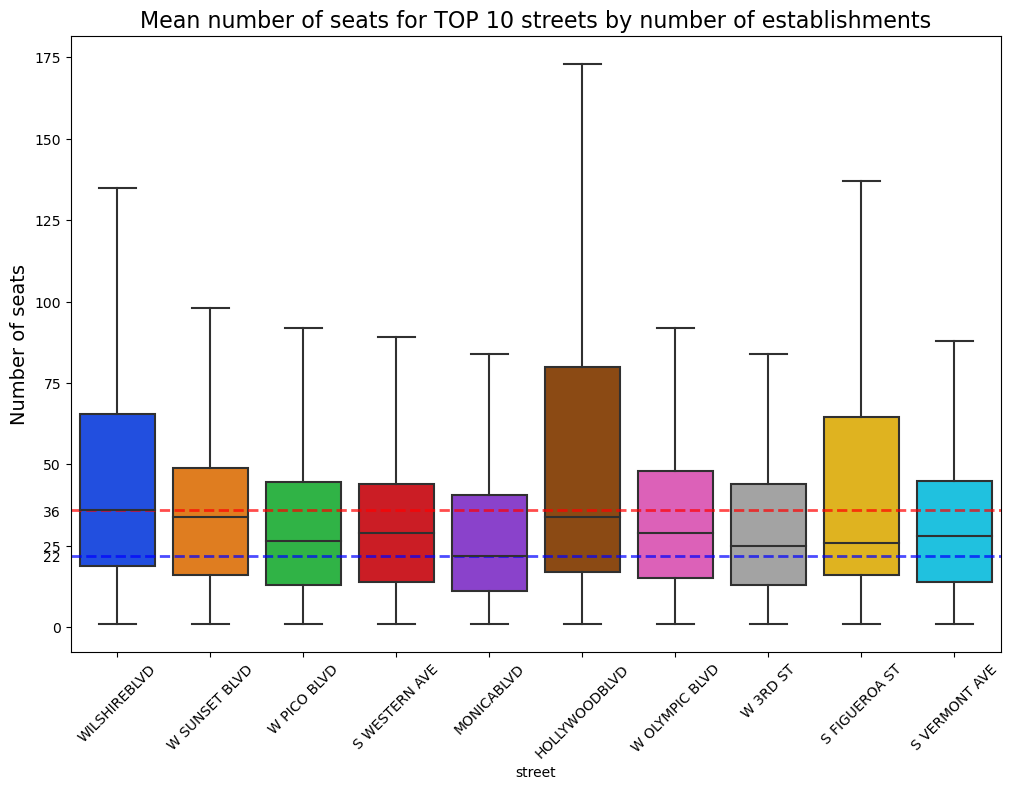

In [109]:
#Making list of TOP 10 streets
streets_list = street_top['street'].to_list()

#Filtering data
df_filt = df[df['street'].isin(streets_list)]

#Plotting the boxplot of total sales braking down by platforms
plt.figure(figsize=(12,8))
palette = sns.color_palette('bright', n_colors=len(df_filt.street))
sns.boxplot(data=df_filt, x='street', y='seats_n', showfliers=False, palette=palette, order=streets_list)

#Plotting horizontal line showing minimum median.
median_min = df_filt.groupby('street')['seats_n'].median().min()
plt.axhline(y=median_min, linewidth=2, color = 'blue', alpha = 0.7, linestyle='--')
plt.text(x=-0.8, y=median_min-2, s=int(median_min), fontsize=10)

#Plotting horizontal line showing maximum median.
median_max = df_filt.groupby('street')['seats_n'].median().max()
plt.axhline(y=median_max, linewidth=2, color = 'red', alpha = 0.7, linestyle='--')
plt.text(x=-0.8, y=median_max-2, s=int(median_max), fontsize=10)

#Adding additional info
plt.xticks(rotation=45)
ax = plt.gca()
ax.set_ylabel('Number of seats', fontsize=14)
plt.title('Mean number of seats for TOP 10 streets by number of establishments', fontsize = 16)

plt.show()

Half of the establishments on popular streets have from 22 to 36 seats. For TOP 5 streets by number of establishments we see the tendency of decrease in average number of seats. But we can not confirm that tendency for the rest of TOP 10 streets. There are 241 establishments on Hollywood blvd, and half of them has 35 seats. There are some places with really huge number of seats (around 200) but there are not many of them.

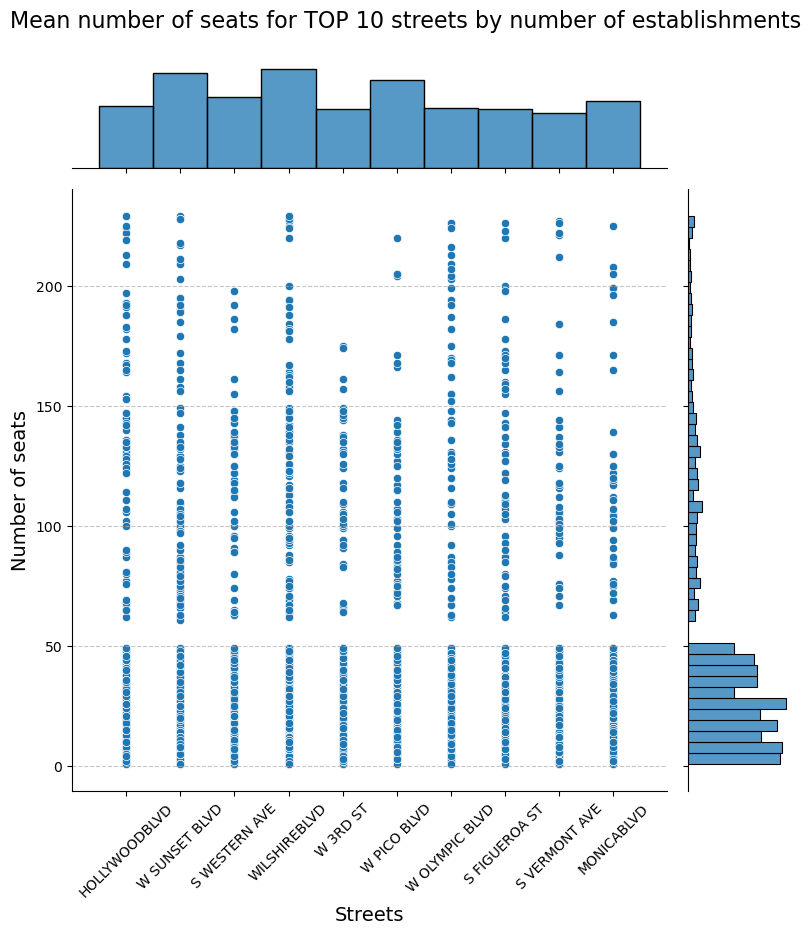

In [113]:


# Plotting joint plot chart
g = sns.jointplot(data=df_filt, x='street', y='seats_n', palette=palette, height=8, ratio=5)

# Adding grid to joint axis
g.ax_joint.grid(axis='y', linestyle='--', alpha=0.7)

# Set title
g.fig.suptitle('Mean number of seats for TOP 10 streets by number of establishments', fontsize=16, y=1.05)

# Set labels
g.ax_joint.set_xlabel('Streets', fontsize=14)
g.ax_joint.set_ylabel('Number of seats', fontsize=14)

# Rotate x-axis labels
for label in g.ax_joint.get_xticklabels():
    label.set_rotation(45)

# Show plot
plt.show()



## General Conclusion

The purpose of the analysis was to prepare market research using open-source data on food establishments in LA. We got a table with the following information: name of the place, address of the place, info whether the place is a chain of places or not, type of the place (restaurant, Cafe, Pizza etc.) and number of seats the place has.

During preprocessing stage of the project we have successfully changed the name of the column where we have the number of seats for each place, replaced just 3 rows with missing values in `chain` column and changed that column to boolean. Also we checked that there are not duplicated info in our data file.

We have found out that **the most of the food places in LA are restaurants. Their share is 75%.** The share of Fast food is 11% and each other place has its share not bigger than 5% of the total number of places.

**All bakeries are chain and most of cafes and fast-food places are chain (61% of cafes and 57% of fast-food). Bars and Restaurants are mostly non-chain (75% of Bars and 68% of restaurants).** The majority of abjects are restaurants, so the will affect to the total result an we see that **most objects (62%) are non-chain, although it depends on type of the object.** For Pizzas we have a draw (52% is non-chain and 48% are chain).

We see that **most of the chain venues have just 1 establishment in LA** and half of chain venues have about 25 seats per establishment in average. We see also some kind of regression. So, **the more establishments a venue has the less number of seats there are in its establishments.** 80% of all chain venues have not more than 49 seats in its establishments. **Generally speaking we can say that typical chain venue has just one establishment and number of seats about 25-30.**

**Restaurants and bars have the biggest average number of seats (45-48) where bakeries and cafes have the smallest number of seats (22-25).** Fast food and pizzas have 28-32 seats in average.

In order to analyze what is geographical distribution of the places we needed to extract street info from the address column We did it with `usaddress` library for Python that we had installed.

We determined TOP 10 streets by number of establishments. All of them have more than 200 establishments on each, and **our TOP 3 are: Wilshire blvd, W Sunset blvd, and W Pico blvd, where there are more than 300 places on each street** And it is interesting that there are 325 streets where there is only one establishment in LA.

**Half of the establishments on popular streets have from 22 to 36 seats.** For TOP 5 streets by number of establishments we see the tendency of decreasing in average number of seats. But we can not confirm that tendency for the rest of TOP 10 streets. There are 241 establishments on Hollywood blvd, and half of them has 35 seats. There are some places with really huge number of seats (around 200) but there are not many of them.

According to the purposes of the analysis we can formulate the following recommended characteristics for opening a Cafe in Los Angeles. The Basis for the recommendations is most common characteristics of the competitors.

* **The best place:** - is TOP 5 streets where there are more than 250 food establishments on each street: WILSHIRE BLVD, W SUNSET BLVD, W PICO BLVD, S WESTERN AVE, MONICA BLVD.
* **Number of seats:** - form 25 to 30, depending on the geographical decision. On more popular street it is better to have more seats.
* **Possibility of chain:** - We can start chain just with one Cafe in LA. It is not uncommon for the region. We can use chain in ads for marketing purposes.

It should be noted also that **Cafes are not popular in LA. 75% of establishments are restaurants.** May be it is better to open a restaurant instead of Cafe according to our findings.

*You can find the results of the analysis in the Presentation:* https://drive.google.com/file/d/1Q5ZS4A_u6Spnufx1hpD4qBs7QciBdNLp/view?usp=sharing